**Introduction:**
Youtube.com keeps list of top trending videos on th eplatform. These videos are not necessarily the most viewed videos. In this project we aimed to find some patterns in differet measures of these videos (including users interactions -views, likes, etc- as well title and category). We will focus on data from US.

Let's start by importing, understanding and cleaning data. Data is provided by Youtube and is publicly available on kaggle.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

us_youtube = pd.read_csv("~/Desktop/USvideos.csv")

print(us_youtube.head())
print(us_youtube.columns)
print(us_youtube.dtypes)
print(us_youtube.shape)

print(len(us_youtube.groupby(['video_id']).nunique()))
print(len(us_youtube.groupby(['title']).nunique()))

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

Dataset has 40949 rows and 16 columns. We are interested in columns of trending and publishing dates, users interactions (views, likes, dislikes, number of comments), and categories.
video_id column has 6351 unique values while title column has 6455 unique values. it seems that some tiles have been changed after becoming trending video. So we will work with the video_id column.

in the following we perform some calculations of the selected columns and combine those in new data frame df to base our analysis on.

In [2]:
trending_days = us_youtube.groupby('video_id')['trending_date'].nunique().reset_index()
trending_days.rename(columns = {'trending_date':'trending_days'}, inplace = True) 
    #number of days that a specific video was on the trending list
    
feedback_begining = us_youtube.groupby('video_id')['views', 'likes', 'dislikes', 'comment_count'].min().reset_index()
feedback_final = us_youtube.groupby('video_id')['views', 'likes', 'dislikes', 'comment_count'].max().reset_index()
    #total number of likes, dislikes and comments at the begining and end of trending poeriod

us_youtube['trending_date'] = pd.to_datetime(us_youtube.trending_date,format='%y.%d.%m', utc=True)
us_youtube['publish_time'] = pd.to_datetime(us_youtube.publish_time)

publishtime = us_youtube.groupby('video_id')['publish_time'].min().reset_index()
publishtime = pd.to_datetime(publishtime['publish_time'])
    #publish date of each unique video ID

us_youtube['days_to_trending'] = us_youtube['trending_date']-us_youtube['publish_time'] 
days_to_trending = us_youtube.groupby('video_id')['days_to_trending'].min().reset_index()
    #total number of days it took a video to become trending video after publishing date (in days) 
    


def time_of_day(x):   #function to categorize publish time in the day
    return (
    0 if 4<=x<8  #'early morning'
    else 
    1 if 8<=x<12 #'morning'
    else
    2 if 12<=x<16 #'afternoon'
    else
    3 if 16<=x<20 #'evening'
    else 
    4 if 20<=x<24 #'night'
    else
    5 #'late night'
    )

publish_time_of_day=[]
for i in range(len(publishtime.dt.hour)):
    publish_time_of_day.append(time_of_day(publishtime.dt.hour[i]))
publish_time_of_day=pd.Series(publish_time_of_day)
    #identifies the time of the day in wich video first published

category = us_youtube.groupby('video_id')['category_id'].min().reset_index()
    #adding category column to the data frame

df = pd.concat([trending_days, feedback_begining[['views', 'likes', 'dislikes', 'comment_count']], 
                feedback_final[['views', 'likes', 'dislikes', 'comment_count']], 
                days_to_trending.days_to_trending.dt.days, publishtime.dt.hour, publish_time_of_day, pd.Series(category['category_id'])], 
                axis=1)
df.columns = ['video_ID','trending_days', 'views_begining','likes_begining', 'dislikes_begining', 'num_comments_begining', 
              'views_final', 'likes_final', 'dislikes_final','num_comments_final', 'days_to_trending','trending_hour', 
              'time_of_day', 'category']
print(df.head())
    #data frame containing iformation for every unique video ID


/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


      video_ID  trending_days  views_begining  likes_begining  \
0  -0CMnp02rNY              6          475965            6531   
1  -0NYY8cqdiQ              1          563746            4429   
2  -1Hm41N0dUs              3         1566807           32752   
3  -1yT-K3c6YI              4          129360            5214   
4  -2RVw2_QyxQ              3           67429             438   

   dislikes_begining  num_comments_begining  views_final  likes_final  \
0                172                    271       800359         9773   
1                 54                     94       563746         4429   
2                393                   1412      2058516        41248   
3                108                    516       231341         7734   
4                 23                     19        71089          460   

   dislikes_final  num_comments_final  days_to_trending  trending_hour  \
0             332                 423                 1             13   
1              54     

Let's look closer at some of the data:

In [3]:
ave_trending_days = np.mean(df['trending_days'])
med_trending_days = np.median(df['trending_days'])
ave_days_to_trending = np.mean(df['days_to_trending'])
med_days_to_trending = np.median(df['days_to_trending'])
print('trending days average: ', round(ave_trending_days, 1), 'and median: ', med_trending_days)
print('days to trending average: ', round(ave_days_to_trending, 1), 'and median: ', med_days_to_trending)

trending_first_day = df[df['days_to_trending']==0].video_ID.count()/len(df)  #percent of videos that went viral the first day
print('percent of videos that went viral the very first day they published: ', round(trending_first_day,2))

ave_views = df.groupby(['trending_days'])['views_begining'].mean()  #mean of views per each trending_days
med_views = df.groupby(['trending_days'])['views_begining'].median() #median of views per each trending_days
trending_days = df['trending_days'].unique()
order = np.argsort(trending_days)
trending_days = np.array(trending_days)[order]
ave_views = np.array(ave_views)[order]
med_views = np.array(med_views)[order]

num_videos_per_day = df.groupby(['trending_days'])['video_ID'].count()  #number of videos associated with each duration of trending
num_videos_per_day = np.array(num_videos_per_day)[order]

trending days average:  6.4 and median:  6.0
days to trending average:  21.5 and median:  1.0
percent of videos that went viral the very first day they published:  0.43


Majority of the trending videos went viral the very first day they published (43%).
Let's plot some of data

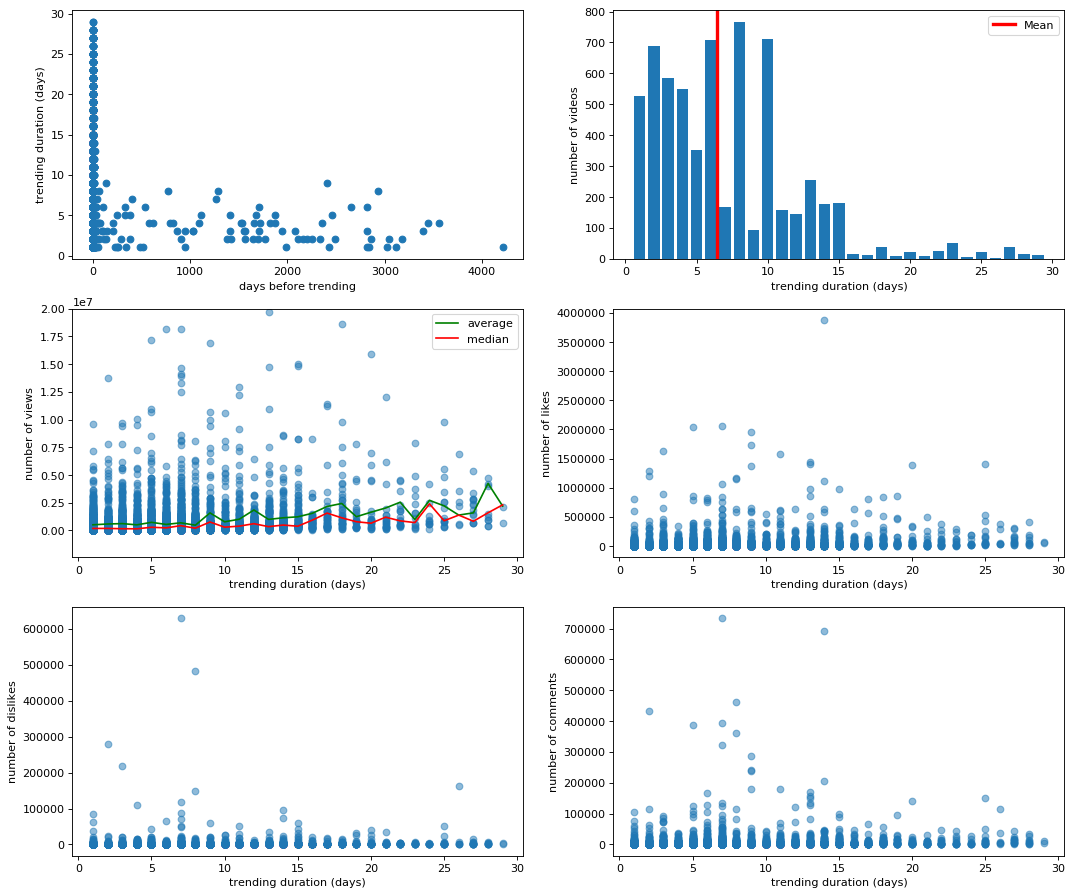

In [4]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3,2,1)
plt.scatter(df['days_to_trending'] ,df['trending_days'])
plt.xlabel('days before trending')
plt.ylabel('trending duration (days)')

plt.subplot(3,2,2)
plt.bar(trending_days, num_videos_per_day)
plt.axvline(ave_trending_days, color='r', linestyle='solid', linewidth=3, label="Mean")
plt.xlabel('trending duration (days)')
plt.ylabel('number of videos')
plt.legend()

plt.subplot(3,2,3)
plt.scatter(df['trending_days'], df['views_begining'],alpha=0.5)
plt.plot(trending_days,ave_views, '-g')
plt.plot(trending_days,med_views, '-r')
plt.xlabel('trending duration (days)')
plt.ylabel('number of views')
plt.legend(['average', 'median'])
plt.ylim(top=2e7)

plt.subplot(3,2,4)
plt.scatter(df['trending_days'], df['likes_begining'],alpha=0.5)
plt.xlabel('trending duration (days)')
plt.ylabel('number of likes')

plt.subplot(3,2,5)
plt.scatter(df['trending_days'], df['dislikes_begining'],alpha=0.5)
plt.xlabel('trending duration (days)')
plt.ylabel('number of dislikes')

plt.subplot(3,2,6)
plt.scatter(df['trending_days'], df['num_comments_begining'],alpha=0.5)
plt.xlabel('trending duration (days)')
plt.ylabel('number of comments')
plt.show()

In general, the more the movie is on the trending list, the more is the number of views. 
Let's look at which categories have the highest number of trending videos:

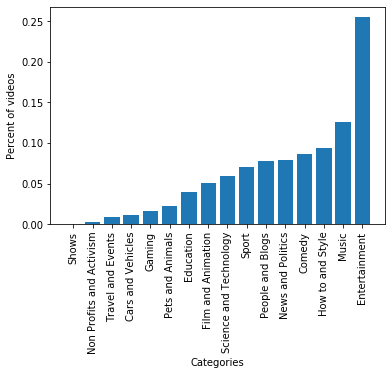

In [5]:
df['category_name'] = np.nan

df.loc[(df["category"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category"] == 10),"category_name"] = 'Music'
df.loc[(df["category"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category"] == 17),"category_name"] = 'Sport'
df.loc[(df["category"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category"] == 27),"category_name"] = 'Education'
df.loc[(df["category"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category"] == 29),"category_name"] = 'Non Profits and Activism'
df.loc[(df["category"] == 43),"category_name"] = 'Shows'

videos_per_category = df.groupby(['category_name'])['video_ID'].count().reset_index()
temp = df.groupby(['category'])['video_ID'].count().reset_index()
videos_per_category_percentage = videos_per_category['video_ID']/df.video_ID.count()

order = np.argsort(videos_per_category_percentage)
videos_per_category_percentage = np.array(videos_per_category_percentage)[order]
categories_name = np.array(videos_per_category['category_name'])[order]
categories_id = np.array(temp['category'])

#print(videos_per_category)
plt.bar(categories_name, videos_per_category_percentage)
plt.xticks(rotation='vertical')
plt.ylabel('Percent of videos')
plt.xlabel('Categories')
plt.show()



Entertainment is by far the most popular category. let's explore trending videos' publishing time 

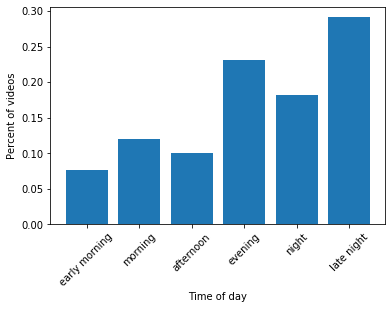

Percent of videos published after 4 pm :  0.5921902062667297


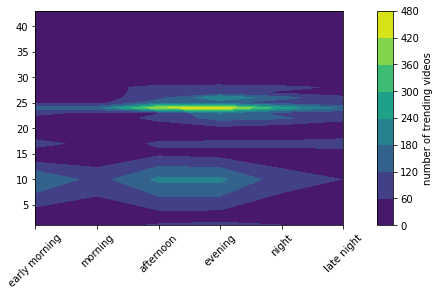

In [7]:
#let's see what time of the day the trending videos are published the most
videos_per_time_of_day = df.groupby(['time_of_day'])['video_ID'].count()/len(df)

plt.bar(df.time_of_day.unique(), videos_per_time_of_day)
plt.xticks([0,1,2,3,4,5], ['early morning', 'morning', 'afternoon', 'evening', 'night', 'late night'],rotation=45)
plt.xlabel('Time of day')
plt.ylabel('Percent of videos')
plt.show()

videos_after_4pm = videos_per_time_of_day[3:].sum()/videos_per_time_of_day.sum()
print('Percent of videos published after 4 pm : ', videos_after_4pm)

#percent of videos per time of the day per category
#videos_per_time_of_day_per_category
temp = df.groupby(['time_of_day', 'category'])['video_ID'].count().reset_index()
temp.dropna(inplace=True)
x = temp.time_of_day.unique()
y = temp.category.unique()
z = [[0 for i in range(len(x))] for j in range(len(y))]
for i in range(len(y)):
    for j in range(len(x)):
        if temp[(temp['time_of_day'] == x[j]) & (temp['category'] == y[i])].empty:
            z[i][j] = 0
        else:
            index = temp.index[(temp['time_of_day'] == x[j]) & (temp['category'] == y[i])]
            z[i][j] = temp['video_ID'][index[0]]
fig2, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(x,y,z)
contour_plot.cmap.set_under('blue')
contour_plot.cmap.set_over('red')
cbar = fig2.colorbar(contour_plot)
cbar.ax.set_ylabel('number of trending videos')
plt.xticks([0,1,2,3,4,5], ['early morning', 'morning', 'afternoon', 'evening', 'night', 'late night'],rotation=45)

order = np.argsort(categories_id)
categories_id = np.array(categories_id)[order]
categories_name = np.array(categories_name)[order]
#plt.yticks(categories_id, categories_name)
plt.show()


In general, majority of trending videos (~60 percent) are published after 4 pm in the day. However, this is not true foe every category. foer example, in Music videos, pick times are early morning and between 12-8 pm.

Now we train a KNN algorithm to predict number of days that video will be on trending list as well as category of the video:

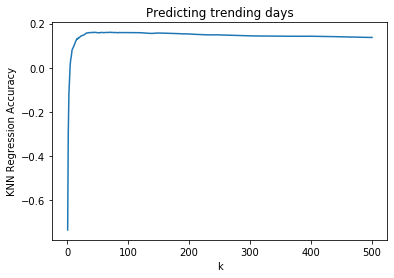

0.1607337280347243


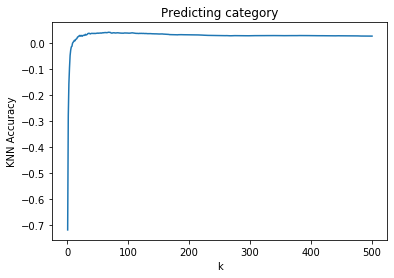

0.040995061804937505


In [8]:
# Importing the Scikit-learn module, normalizing the data, training and testing 
# a KNN model to predict trending days and category ofthe video
# and finding the optimal k

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Predicting trending days using KNN regression
features = df[['views_begining','likes_begining', 'dislikes_begining', 'num_comments_begining', 
              'category']]

min_max_scaler = preprocessing.MinMaxScaler()
features_values = features.values

features_values_scaled = min_max_scaler.fit_transform(features_values) #scaling data
features = pd.DataFrame(features_values_scaled, columns=features.columns)
labels = df['trending_days']
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=1) #splittind data

scores = []
for k in range(1, 501):
    regressor = KNeighborsRegressor(n_neighbors = k, weights = "distance")
    regressor.fit(features_train, labels_train)
    scores.append(regressor.score(features_test, labels_test))

plt.plot(range(1, 501), scores)
plt.xlabel('k')
plt.ylabel('KNN Regression Accuracy')
plt.title('Predicting trending days')
plt.show()
print(max(scores))

#predicting category of trending videos using KNN 
features = df[['views_begining','likes_begining', 'dislikes_begining', 'num_comments_begining', 
              'trending_days']]

min_max_scaler = preprocessing.MinMaxScaler()
features_values = features.values

features_values_scaled = min_max_scaler.fit_transform(features_values)
features = pd.DataFrame(features_values_scaled, columns=features.columns)
labels = df['category']
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=1)

scores = []
for k in range(1, 501):
    classifier = KNeighborsRegressor(n_neighbors = k, weights = "distance")
    classifier.fit(features_train, labels_train)
    scores.append(classifier.score(features_test, labels_test))

plt.plot(range(1, 501), scores)
plt.xlabel('k')
plt.ylabel('KNN Accuracy')
plt.title('Predicting category')
plt.show()
print(max(scores))